In [1]:
import numpy as np
import dynalearn as dl
import matplotlib.pyplot as plt
import tensorflow as tf
import os

/home/charles/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/charles/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/charles/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/charles/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
dynamics_config = {
        "name": "PlanckSIS",
        "params": {"temperature": 6, "recovery": 0.08, "init": "None"},
    }
graph_config = {"name": "BAGraph", "params": {"N": 1000, "M": 2}}
model_config = dl.models.GNNConfig.SISGNN()
metric_config = dl.metrics.MetricsConfig.PlanckSISMetrics()

metric_config.num_nodes = 2000
num_sample = 10000
name = "plancksis-ba-ns{0}".format(num_sample)

path_to_model = "../data/training/models"
path_to_data = os.path.join("../data/training", name)
training_config = dl.TrainingConfig.default()
training_config.num_sample = num_sample
training_config.step_per_epoch = num_sample

config = {
    "name": name,
    "graph": graph_config,
    "dynamics": dynamics_config,
    "model": {"name": "EpidemicPredictor", "config": model_config},

    "generator": {
        "name": "DynamicsGenerator",
        "config": dl.datasets.GeneratorConfig.default(),
        "sampler": {
            "name": "StateBiasedSampler",
            "config": dl.datasets.samplers.SamplerConfig.BiasedSamplerDefault(
                dynamics_config, 0.6
            ),
        },
    },
    "metrics": {
        "name": [
            "TrueStarLTPMetrics",
            "GNNStarLTPMetrics",
            "TruePEMFMetrics",
            "GNNPEMFMetrics",
            "TruePESSMetrics",
            "GNNPESSMetrics",
        ],
        "config": metric_config,
    },
    "training": training_config,
    "path_to_data": path_to_data,
    "path_to_model": path_to_model,
}

In [3]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = tf.Session(config=tf_config)
experiment = dl.Experiment(config, verbose=1)


In [17]:
experiment.load_model(best=True)
experiment.metrics["TrueStarLTPMetrics"].compute(experiment)
experiment.metrics["GNNStarLTPMetrics"].compute(experiment)

100%|██████████| 1340/1340 [00:00<00:00, 7163.63it/s]

Computing TrueStarLTPMetrics



  0%|          | 0/1340 [00:00<?, ?it/s]

Computing GNNStarLTPMetrics


100%|██████████| 1340/1340 [00:01<00:00, 1134.01it/s]


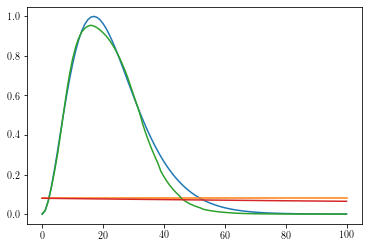

In [18]:
data = experiment.metrics["TrueStarLTPMetrics"].aggregate(in_state=0, out_state=1)
plt.plot(data[0], data[1])
data = experiment.metrics["TrueStarLTPMetrics"].aggregate(in_state=1, out_state=0)
plt.plot(data[0], data[1])

data = experiment.metrics["GNNStarLTPMetrics"].aggregate(in_state=0, out_state=1)
plt.plot(data[0], data[1])
data = experiment.metrics["GNNStarLTPMetrics"].aggregate(in_state=1, out_state=0)
plt.plot(data[0], data[1])

In [4]:
experiment.load_model(best=True)

experiment.metrics["TruePEMFMetrics"].compute(experiment)
experiment.metrics["GNNPEMFMetrics"].compute(experiment)

Thresholds:   0%|          | 0/34 [00:00<?, ?it/s]

Computing TruePEMFMetrics


Thresholds:   0%|          | 0/34 [00:00<?, ?it/s]

Computing GNNPEMFMetrics


Fixed points: 100%|██████████| 140/140 [00:46<00:00,  3.01it/s]


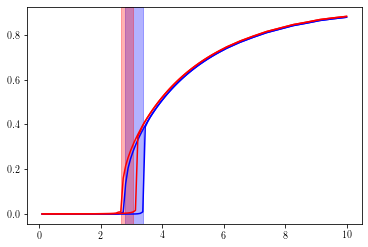

In [5]:
x = experiment.metrics["TruePEMFMetrics"].data["parameters"]
y = experiment.metrics["TruePEMFMetrics"].data["fixed_points"]
t = experiment.metrics["TruePEMFMetrics"].data["thresholds"]
plt.plot(x, 1 - y[0,:,0], 'b')
plt.plot(x, 1 - y[1,:,0], 'b')
plt.axvspan(t[0], t[1], color="b", alpha=0.3)

x = experiment.metrics["GNNPEMFMetrics"].data["parameters"]
y = experiment.metrics["GNNPEMFMetrics"].data["fixed_points"]
t = experiment.metrics["GNNPEMFMetrics"].data["thresholds"]
plt.plot(x, 1 - y[0,:,0], 'r')
plt.plot(x, 1 - y[1,:,0], 'r')
plt.axvspan(t[0], t[1], color="r", alpha=0.3)

# plt.axvline(t[0], color="b", alpha=0.3, linestyle='-')

# x = experiment.metrics["PoissonEpidemicsMFMetrics"].parameters
# y1 = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_low_fp"]
# y2 = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_high_fp"]
# t = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_thresholds"]
# plt.plot(x, 1 - y1[:,0], ls='--', c='r')
# plt.plot(x, 1 - y2[:,0], ls='--', c='r')
# plt.axvspan(t[0], t[1], color="r", alpha=0.3)
# plt.xlim([2, 6])

In [12]:
experiment.load_model(best=True)

experiment.metrics["TruePESSMetrics"].epsilon = 1e-2
experiment.metrics["TruePESSMetrics"].num_samples = 10
experiment.metrics["TruePESSMetrics"].parameters = np.linspace(2, 6, 10)
experiment.metrics["TruePESSMetrics"].burn = 200

experiment.metrics["GNNPESSMetrics"].epsilon = 1e-2
experiment.metrics["GNNPESSMetrics"].num_samples = 10
experiment.metrics["GNNPESSMetrics"].parameters = np.linspace(2, 6, 10)
experiment.metrics["GNNPESSMetrics"].burn = 200

experiment.metrics["TruePESSMetrics"].compute(experiment)
experiment.metrics["GNNPESSMetrics"].compute(experiment)

  0%|          | 0/200 [00:00<?, ?it/s]

Computing TruePESSMetrics


  0%|          | 0/200 [00:00<?, ?it/s]

Computing GNNPESSMetrics


100%|██████████| 200/200 [14:48<00:00,  4.44s/it]


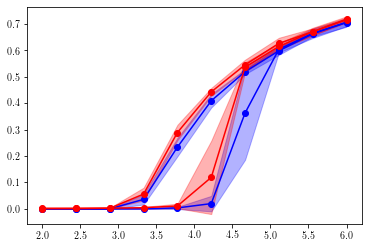

In [13]:
x = experiment.metrics["TruePESSMetrics"].data["parameters"]
y = experiment.metrics["TruePESSMetrics"].data["avg"]
err = experiment.metrics["TruePESSMetrics"].data["std"]
plt.plot(x, 1 - y[0,:,0], 'b', marker='o')
plt.plot(x, 1 - y[1,:,0], 'b', marker='o')
plt.fill_between(x, 1 - y[0,:,0] - err[0,:,0], 1 - y[0,:,0] + err[0,:,0], color='b', alpha=0.3)
plt.fill_between(x, 1 - y[1,:,0] - err[1,:,0], 1 - y[1,:,0] + err[1,:,0], color='b', alpha=0.3)

x = experiment.metrics["GNNPESSMetrics"].data["parameters"]
y = experiment.metrics["GNNPESSMetrics"].data["avg"]
err = experiment.metrics["GNNPESSMetrics"].data["std"]
plt.plot(x, 1 - y[0,:,0], 'r', marker='o')
plt.plot(x, 1 - y[1,:,0], 'r', marker='o')
plt.fill_between(x, 1 - y[0,:,0] - err[0,:,0], 1 - y[0,:,0] + err[0,:,0], color='r', alpha=0.3)
plt.fill_between(x, 1 - y[1,:,0] - err[1,:,0], 1 - y[1,:,0] + err[1,:,0], color='r', alpha=0.3)

# plt.xlim([2, 6])
